In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batchSize = 64

In [6]:
def get_train_valid_loader(data_dir,batch_size,augment,random_seed,valid_size=0.1,shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,download=True, transform=train_transform, )

    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform, )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,  batch_size, shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

In [7]:
# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './Cifar10', batch_size = batchSize, augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './Cifar10', batch_size = batchSize)

100%|██████████| 170M/170M [00:05<00:00, 28.4MB/s] 


Extracting ./Cifar10\cifar-10-python.tar.gz to ./Cifar10
Files already downloaded and verified
Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


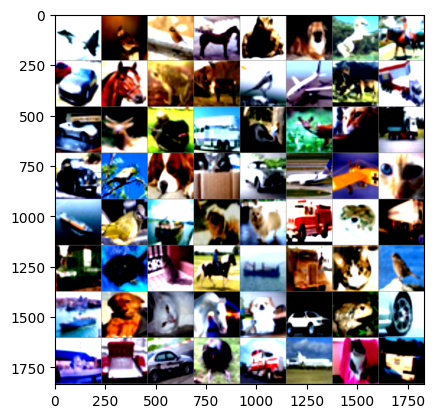

plane bird  bird  horse frog  dog   horse horse car   horse frog  deer  bird  plane deer  truck car   deer  dog   truck bird  deer  cat   truck car   bird  dog   cat   car   plane plane cat   ship  bird  ship  dog   dog   truck frog  truck truck dog   cat   horse ship  truck cat   bird  ship  dog   cat   horse dog   car   frog  car   ship  truck car   bird  truck plane cat   car  


In [11]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [13]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [14]:
num_classes = 10
num_epochs = 20
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
# Train the model
total_step = len(train_loader)

In [16]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.0719
Accuracy of the network on the 5000 validation images: 59.81 %
Epoch [2/20], Step [704/704], Loss: 1.3118
Accuracy of the network on the 5000 validation images: 68.11 %
Epoch [3/20], Step [704/704], Loss: 1.4713
Accuracy of the network on the 5000 validation images: 69.65 %
Epoch [4/20], Step [704/704], Loss: 1.2918
Accuracy of the network on the 5000 validation images: 75.19 %
Epoch [5/20], Step [704/704], Loss: 0.9219
Accuracy of the network on the 5000 validation images: 77.47 %
Epoch [6/20], Step [704/704], Loss: 0.6828
Accuracy of the network on the 5000 validation images: 77.84 %
Epoch [7/20], Step [704/704], Loss: 0.3045
Accuracy of the network on the 5000 validation images: 78.54 %
Epoch [8/20], Step [704/704], Loss: 1.0087
Accuracy of the network on the 5000 validation images: 78.63 %
Epoch [9/20], Step [704/704], Loss: 0.5275
Accuracy of the network on the 5000 validation images: 80.39 %
Epoch [10/20], Step [704/704], Loss: 0.3058
Ac

In [17]:
PATH = 'Models/'

In [18]:
torch.save(model.state_dict(), f="AlexNet_Baseline.pt")

Accuracy of the network on the 10000 test images: 82.39 %


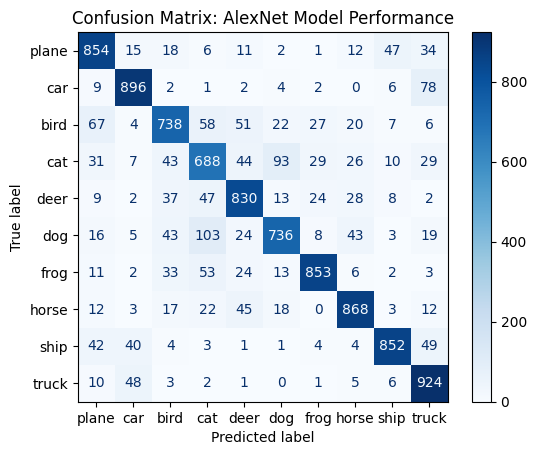

In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

    cm = confusion_matrix(all_labels, all_predictions)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: AlexNet Model Performance")
    plt.show()

